# Deep learning for hyperspectral image processing: 3-D convolutional neural networks
This notebook demonstrates application of 3-Dimensional Convolutional Neural Network (3-D CNN) models to land use classification. Two separate notebooks are also available, describing application of 2-Dimensional Convolutional neural network [(2-D CNN)](deep_learning_2D_CNN.ipynb) as well as Multi-Layer Perceptron [(MLP)](deep_learning_MLP.ipynb) models to land use classification using hyperspectral data. 

## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module are were for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.  

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

2025-02-07 15:15:27.148066: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 15:15:27.171509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 15:15:27.502297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperspectral dataset
A set of publically-available hyperspectral imageray datasets can be downloaded form [this](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) website. The Indian Pine dataset was downloaded and used in this notebook. The dataset consists of 150$\times$150 pixels with 200 refelactance bands. The ground truth data for the dataset consists of 16 different classes. A summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy. 

In [2]:
data_folder = 'Datasets'
data_file= 'Indian_pines_corrected'
gt_file = 'Indian_pines_gt'
data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('indian_pines_corrected')
gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(145, 145, 200) (145, 145)


## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.75 as the split ratio (75% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data in the gourd truth data file are represented by 0 . Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [3]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 7679.
Number of test samples = 2569.


A portion of training data can optionally be set aside for validation.

In [4]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [5]:
data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set.shape


(145, 145, 69)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

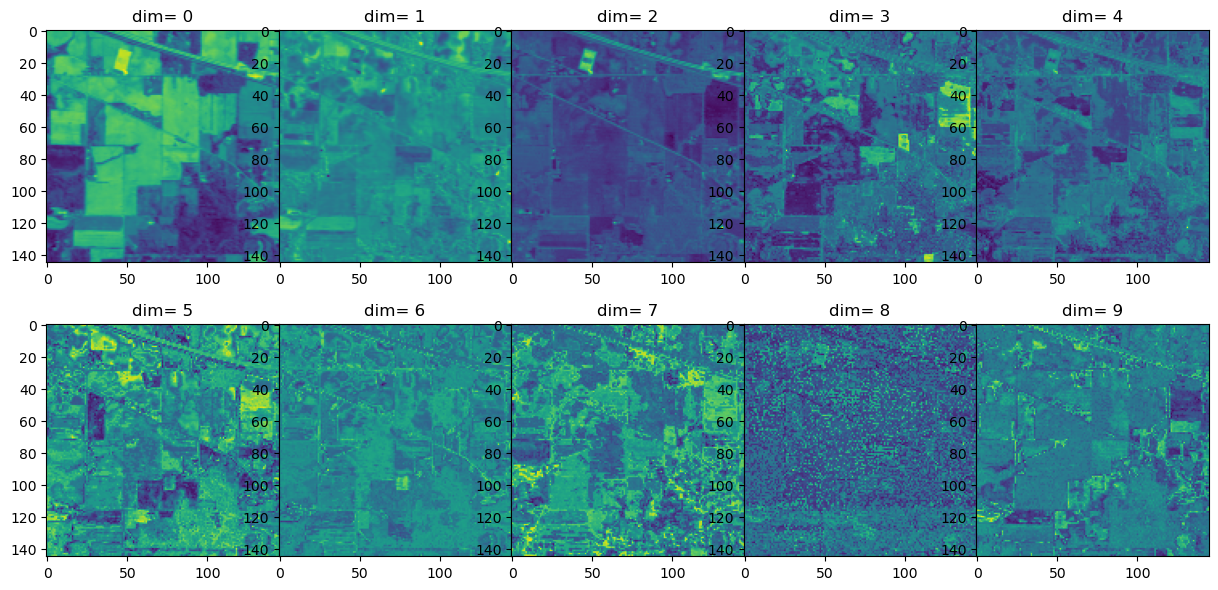

In [7]:
fig, axes = plt.subplots(2,5, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:,:,numb])
    axe.set_title('dim='+' '+str(numb))
    
fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [8]:
data_set = util.rescale_data(data_set)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models. 
In this notebook, a 3-D CNN model with a 'path_size' of 9 was used for classification.  

In [ ]:
patch_size=9
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

# Adding a new axis to make the input shape compatible to a 3-D conv network
train_input_sub, val_input, test_input = np.array([np.expand_dims(elm,-1) for elm
                                                   in (train_input_sub, val_input, test_input)])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

## Creating a 3-D CNN model
The network architecture consists of a 3-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of (1, 1, 3). The third layer is a 3-D convolutional layer, followed by a maximum pooling layer. The 'zero_pad_3D' function checks if the spectral dimension is a multiple of the stride size, and zero-pad the output of the pooling layer if it is not a multiple of the stride size (see zero_pad_3D' function documentation for more details). The sixth layer is a 3-D convolutional layer whose output is flatten by a subsequent 'flatten' layer. The 'flatten' layer is followed by a 'drop-out' layer with a drop rate of 0.35  and three subsequent 'dense' layers.    

In [27]:
kernel_size = (3, 3, 5) # 3-D convolutional layer kernel size
pool_size = (1, 1, 3)   # 3-D pooling kernel size
lr = 1e-3               # learning rate
l2_parm = 1e-3          # l2 regularization parameter
batch_size = 2**5       # batch size for training model
filters_1 = 2**6        # Number of filters in the first convolutional layer
filters_2 = 2**5        # Number of filters in the second convolutional layer
filters_3 = 2**5        # Number of filters in the third convolutional layer
drop_rate = 0.35        # Drop rate in the 'drop out' layer
units_1 = 2**7          # Number of neurons in the first 'dense' layer
units_2 = 2**7          # Number of neurons in the second 'dense' layer

input_shape = train_input_sub.shape[1:]

# Building a 3-D Convolutional network model
cnn_model = models.Sequential()

# conv_1
cnn_model.add(layer=layers.Conv3D(filters=filters_1,                            
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=train_input_sub.shape[1:]))
# max_pool_1
cnn_model.add(layer=layers.MaxPool3D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))
# zero_padding_1
util.zero_pad_3D(cnn_model)

# conv_2
cnn_model.add(layer=layers.Conv3D(filters=filters_2,
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm))) 
# max_pool_2
cnn_model.add(layer=layers.MaxPool3D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))
# zero_padding_2
util.zero_pad_3D(cnn_model)
# conv_3
cnn_model.add(layer=layers.Conv3D(filters=filters_3, kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm)))
# flatten_1
cnn_model.add(layer=layers.Flatten())
# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))
# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))
# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))
# dense_3 (output_layer)
cnn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 7, 7, 65, 64)      2944      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 7, 21, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 17, 32)      92192     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 5, 5, 32)       0         
_________________________________________________________________
zero_padding3d_1 (ZeroPaddin (None, 5, 5, 6, 32)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 3, 2, 32)       46112     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
__________

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors) 

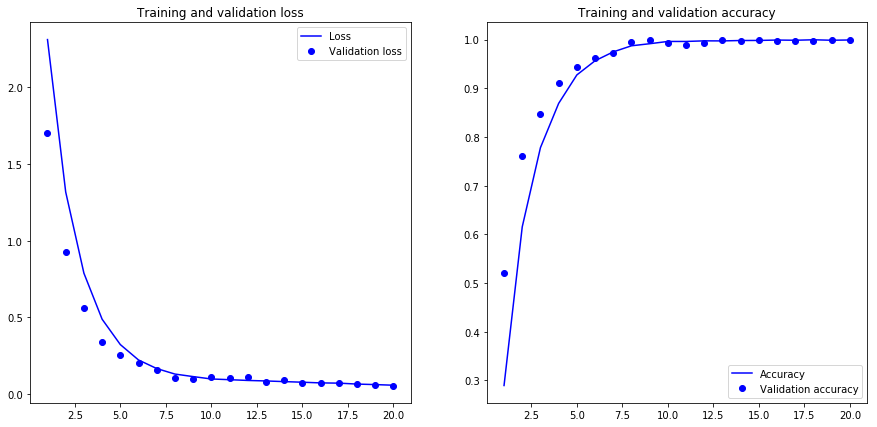

In [28]:
lr = 1e-4
batch_size = 2**5

# Compiling the modele
# Compiling the model
cnn_model.compile(optimizer=optimizers.RMSprop(lr=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=20, validation_data=(val_input, y_val), verbose=False)

# Plotting history
epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()

## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [12]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.12387575281065417
Overall accuracy = 0.9848189957181783

Class ID     Accuracy
______________________________
 1            0.9167
______________________________
 2            0.9944
______________________________
 3            0.9856
______________________________
 4            0.9333
______________________________
 5            0.9835
______________________________
 6            1.0000
______________________________
 7            1.0000
______________________________
 8            1.0000
______________________________
 9            1.0000
______________________________
10            0.9712
______________________________
11            0.9805
______________________________
12            0.9732
______________________________
13            1.0000
______________________________
14            0.9968
______________________________
15            0.9691
______________________________
16            1.0000
______________________________


## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels. 

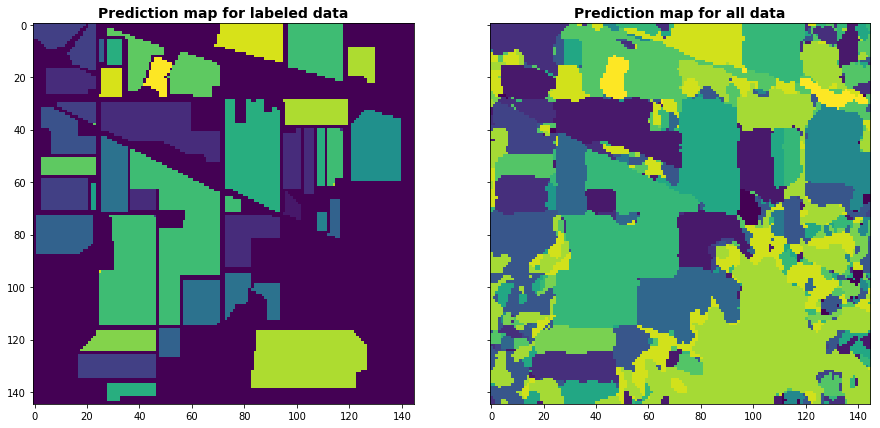

In [29]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(cnn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
ax1.imshow(partial_map)
ax1.set_title('Prediction map for labeled data', fontweight="bold", fontsize='14')
ax2.imshow(full_map)
ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
plt.show()

As indicated, the salt-and-pepper noise resulting from classification using the [MLP model](deep_learning_MLP.ipynb) is not present in the CNN model predictions.

See also:
### [Deep learning for hyperspectral image processing: Multi-layer perceptron networks](deep_learning_MLP.ipynb)
### [Deep learning for hyperspectral image processing: 2-D convolutional neural networks](deep_learning_2D_CNN.ipynb)
### [Deep learning for hyperspectral image processing: 3-D convolutional neural networks](deep_learning_3D_CNN.ipynb)